# H2O.ai XGBoost GPU Benchmarks

In this notebook, we benchmark the latest version of [XGBoost](https://github.com/h2oai/xgboost), the well-known Kaggle-winning gradient boosting algorithm, and in particular, the [XGBoost GPU plugin](https://github.com/h2oai/xgboost/blob/master/plugin/updater_gpu/README.md).

In [26]:
## For comparison between 1 GPU and 1 CPU, we use only 1 CPU:
#numactl --physcpubind=0 -C 0 --cpunodebind=0 -N 0 -m 0

## This will ensure that we only use the first CPU on multi-CPU systems

![1CPU](./1CPUonNUMA.png)

In [2]:
# First time only: install xgboost, and restart the kernel afterwards
#import os
#os.system("mkdir -p tmp && cd tmp && git clone https://github.com/h2oai/xgboost --recursive && cd xgboost && mkdir build && cd build && cmake .. -DPLUGIN_UPDATER_GPU=ON -DCUB_DIRECTORY=../cub -DCUDA_NVCC_FLAGS=\"--expt-extended-lambda -arch=sm_30\" && make -j; make; cd ../python-package && sudo python3.6 setup.py install")

In [3]:
%matplotlib inline
import xgboost as xgb
import pandas as pd
import numpy as np
import scipy as sp
import os
import time
from sklearn import metrics

In [4]:
#https://s3.amazonaws.com/h2o-public-test-data/bigdata/laptop/higgs_head_2M.csv
path = "/opt/higgs_head_2M.csv"
num_class = 2
num_round = 100
learn_rate = 0.02
max_depth = 10

## Parse data into a Pandas Frame
df = pd.read_csv(path, header=None)

In [5]:
df_target = df.iloc[:,0]
df.drop(df.iloc[:,0], axis=1, inplace=True)
cols = df.columns.values
df.shape

(2000000, 27)

In [6]:
train = df

In [7]:
train_target = df_target

In [8]:
print(train.shape)

(2000000, 27)


In [9]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                80
On-line CPU(s) list:   0-79
Thread(s) per core:    2
Core(s) per socket:    20
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 79
Model name:            Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz
Stepping:              1
CPU MHz:               2201.000
CPU max MHz:           2201.0000
CPU min MHz:           1200.0000
BogoMIPS:              4391.41
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              51200K
NUMA node0 CPU(s):     0-19,40-59
NUMA node1 CPU(s):     20-39,60-79
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtop

In [10]:
!cat /proc/meminfo | grep MemTotal

MemTotal:       528278376 kB


In [11]:
!nvidia-smi -L

GPU 0: Tesla P100-SXM2-16GB (UUID: GPU-77864ed9-e817-3463-e5be-bf4c4c563a4c)
GPU 1: Tesla P100-SXM2-16GB (UUID: GPU-e8ece262-f677-038f-5b40-6cc86f978487)
GPU 2: Tesla P100-SXM2-16GB (UUID: GPU-7d996bf3-876b-1439-e447-ec8fb235fd98)
GPU 3: Tesla P100-SXM2-16GB (UUID: GPU-151287c0-bb97-6f82-fedb-a88273ee5447)
GPU 4: Tesla P100-SXM2-16GB (UUID: GPU-99c5cdb5-54b9-ccd2-eb51-a32850d37ebf)
GPU 5: Tesla P100-SXM2-16GB (UUID: GPU-d2d22332-f462-061e-606a-3d6a5ea89848)
GPU 6: Tesla P100-SXM2-16GB (UUID: GPU-5cc8b757-ee04-3bbb-5866-1f9f8c404a54)
GPU 7: Tesla P100-SXM2-16GB (UUID: GPU-3016922d-1da7-46cd-17f3-cb6b3ab17bc3)


In [12]:
def runXGBoost(param):
    have_updater = "updater" in param.keys()
    label = "XGBoost " \
        + ("GPU hist" if have_updater and param["updater"]=="grow_gpu_hist" else "GPU exact" if have_updater and param["updater"]=="grow_gpu" else "CPU") \
        + " " + (param["tree_method"] if "updater" not in param.keys() else "")
    print(label)
    print("=====================")
    for k, v in param.items():
        print(k, v)
    print("=====================")
    
    t_start = time.time()
    dtrain = xgb.DMatrix(train.values, label = train_target.values, feature_names=[str(c) for c in cols])
    tt = time.time() - t_start
    print("Time to create DMatrix (sec): ", tt)
    dmatrix_times.append(tt)
    
    t_start = time.time()
    bst = xgb.train(param, dtrain, num_round)
    tt = time.time() - t_start
    print("Time to train (sec): ", tt)
    train_times.append(tt)

    t_start = time.time()
    preds = bst.predict(dtrain)
    tt = time.time() - t_start
    print("Time to predict (sec): ", tt)
    score_times.append(tt)

    labels = dtrain.get_label()
    auc = metrics.roc_auc_score(labels, preds)
    print("Training AUC:", auc)
    valid_aucs.append(auc)
    plot_labels.append(label)
    
    fs = bst.get_fscore()
    
    # Optional: Uncomment to show variable importance
    #varimp = pd.DataFrame({'Importance': list(fs.values()), 'Feature': list(fs.keys())})
    #varimp.sort_values(by = 'Importance', inplace = True, ascending = False)
    #varimp.head(10).plot(label='importance',kind="barh",x="Feature",y="Importance").invert_yaxis()

In [13]:
valid_aucs = []
dmatrix_times = []
train_times = []
score_times = []
plot_labels = []

In [14]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"exact"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost CPU exact
objective reg:logistic
max_depth 10
eta 0.02
tree_method exact
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  1.3018410205841064
Time to train (sec):  156.89837384223938
Time to predict (sec):  0.009923458099365234
Training AUC: 0.814825032969


In [15]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"approx"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost CPU approx
objective reg:logistic
max_depth 10
eta 0.02
tree_method approx
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  1.3085696697235107
Time to train (sec):  112.52851748466492
Time to predict (sec):  0.006969928741455078
Training AUC: 0.812860299622


In [16]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"hist"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost CPU hist
objective reg:logistic
max_depth 10
eta 0.02
tree_method hist
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  1.0684473514556885
Time to train (sec):  74.41968321800232
Time to predict (sec):  0.007252216339111328
Training AUC: 0.813941675296


In [17]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"exact"
    , "updater":"grow_gpu"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost GPU exact 
objective reg:logistic
max_depth 10
eta 0.02
tree_method exact
updater grow_gpu
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  1.0562524795532227
Time to train (sec):  69.6183352470398
Time to predict (sec):  0.0040585994720458984
Training AUC: 0.814253361342


In [18]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"exact"
    , "updater":"grow_gpu_hist"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost GPU hist 
objective reg:logistic
max_depth 10
eta 0.02
tree_method exact
updater grow_gpu_hist
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  1.059044361114502
Time to train (sec):  5.205292224884033
Time to predict (sec):  0.0067708492279052734
Training AUC: 0.813602860314


In [19]:
data = pd.DataFrame({'algorithm'  :plot_labels,
                     'dmatrix time':dmatrix_times,
                     'training time':train_times,
                     'scoring time':score_times,
                     'training AUC' :valid_aucs}).sort_values(by="training time")
data

,algorithm,dmatrix time,scoring time,training AUC,training time
4,XGBoost GPU hist,1.059044,0.006771,0.813603,5.205292
3,XGBoost GPU exact,1.056252,0.004059,0.814253,69.618335
2,XGBoost CPU hist,1.068447,0.007252,0.813942,74.419683
1,XGBoost CPU approx,1.308570,0.006970,0.812860,112.528517
0,XGBoost CPU exact,1.301841,0.009923,0.814825,156.898374


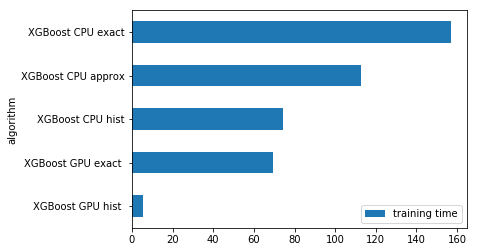

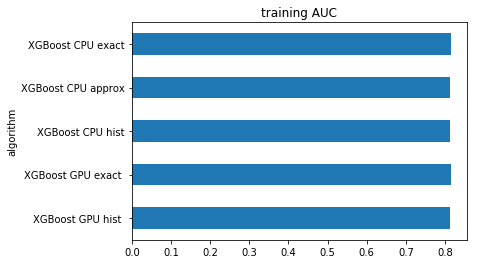

In [27]:
data.plot(label="training time",kind='barh',x='algorithm',y='training time')
data.plot(title="training AUC",kind='barh',x='algorithm',y='training AUC',legend=False)